## **PyTorch Experiment Tracking**



We have trained a fair few models, and so far we've kept track of them via Python dictionaries, or just printing them out during trainings.

What if you want to run many different models at once.

**Experiment Tracking**

Machine learning and deep learning are very experimental, experiment tracking helps us to figure out what works and what doesnt.

### Why Track Experiemnts?

As the number of experiments we run starts to increase, this naive way of tracking could get out of hand. 


#### Different Ways to track machine learning experiments


1. Python dictionaries, CSV files -  easy to setup, hard to keep track of large number of experiments

2. `Tensorboard` - extensions built into Pytorch, user-experience not as nice as other options

3. Weigths & Biases Experiment Tracking - `wandb`, incredible user experience, requires external resource outside of pytorch

4. `MLFlow` - fully open source, little bit harder to setup a remote tracking server

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms

from torchinfo import summary


from going_modular import data_setup, engine, model_builder, utils

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Helper function set seeds




In [4]:
def set_seeds(seed:int= 135):
    """
    Set random seeds for reproducibility.
    
    Args:
        seed (int): The seed value to set for random number generators.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Random seed set to {seed}")

### **Get Data**

We'll need a dataset, let's work on the foodvision model. We already have the data, let's make datasets and dataloader

In [5]:
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manual transforms: {manual_transforms}")


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32)

print(f"Class names: {class_names}")



Manual transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Class names: ['pizza', 'steak', 'sushi']


### Create DataLoaders using automatically created transforms


Let's make use of `automatic transform`

In [6]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

automatic_transforms = weights.transforms()
print(f"Automatic transforms: {automatic_transforms}")



train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32)  

print(f"Class names: {class_names}")

Automatic transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
Class names: ['pizza', 'steak', 'sushi']


### Getting a pretrained model, freezing the base layers and changing the classifier head

Before we run and track multiple modelling experiments, let's see what it's like to run and track a single one

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
print(f"Using weights: {weights}")

model = torchvision.models.efficientnet_b0(weights=weights).to(device)


model

Using weights: EfficientNet_B0_Weights.IMAGENET1K_V1


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Let's turn it into a feature extractor model, in essence, we'll freeze the base layers of model, and we'll change the classifier head to suit the number of classes we're working with 

In [8]:
for param in model.features.parameters():
    param.requires_grad = False
    # freezing the base layers of the model

set_seeds()


model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True).to(device))


Random seed set to 135


In [9]:
summary(model, input_size=(32, 3, 224, 224), device=device)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 3]                   --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

### Train model and track results

Model is ready to go, let's get ready to train it by creating a loss function and optimizer. Since we are working with multiple classes, we'll use `torch.nn.CrossEntropyLoss()` as the loss function, and we'll stick with `torch.optim.Adam()` with learning rate of `0.001` for the optimizer.

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Previously we tracked our modelling experiments using multiple python dictionaries, but this time we'll use `torch.utils.tensorboard.SummaryWriter()` class to save various parts of our model's training progress to file.



In [11]:
try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    print("TensorBoard not found, please install it with `pip install tensorboard`")
    %pip install tensorboard
    from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter(log_dir="runs/experiment_tracking")

We'll get the `train()` function from `engine.py` and adjust it to use `writer`. We'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

We can do this with `writer.add_scalars(main_tag, tag_scalar_dict)`, where
- `main_tag` - the name of the scalars being tracked
- `tag_scalar_dict` - a dictionary of the values being tricked



Once we've finished tracking values, we'll call `writer.close()` to tell the `writer` to stop looking for values to track. To start modifying `train()` we'll also import `train_step()` and `test_step()` from `engine.py`

In [12]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [13]:
set_seeds()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

Random seed set to 135


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0372 | train_acc: 0.5117 | test_loss: 0.8858 | test_acc: 0.7528


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

Epoch: 2 | train_loss: 0.8265 | train_acc: 0.6875 | test_loss: 0.8079 | test_acc: 0.7121


 40%|████      | 2/5 [00:04<00:06,  2.23s/it]

Epoch: 3 | train_loss: 0.7270 | train_acc: 0.7812 | test_loss: 0.7127 | test_acc: 0.8239


 60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

Epoch: 4 | train_loss: 0.6946 | train_acc: 0.7109 | test_loss: 0.6591 | test_acc: 0.8248


 80%|████████  | 4/5 [00:08<00:02,  2.10s/it]

Epoch: 5 | train_loss: 0.5917 | train_acc: 0.7969 | test_loss: 0.5643 | test_acc: 0.8551


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Let's see the save location of `run/experiment_tracking`

In [14]:
results

{'train_loss': [1.0371683612465858,
  0.8264739885926247,
  0.7270016297698021,
  0.6946283541619778,
  0.5917394310235977],
 'train_acc': [0.51171875, 0.6875, 0.78125, 0.7109375, 0.796875],
 'test_loss': [0.8857918580373129,
  0.8078834215799967,
  0.7127312421798706,
  0.659054696559906,
  0.564283033212026],
 'test_acc': [0.7528409090909092,
  0.712121212121212,
  0.8238636363636364,
  0.8248106060606061,
  0.8551136363636364]}

### View the model's result in TensorBoard

The `SummaryWriter()` class stores our model's results in a directory called `runs/` in TensorBoard format by default. 

```python
%load_ext tensorboard
%tensorboard --logdir runs/experiment_tracking
```

#### Helper function to build `SummaryWriter()`

In [15]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [16]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2025-07-16/data_10_percent/effnetb0/5_epochs...


### Update the `train()` function to include a `writer` parameter

Our `create_writer()` function is working fine, now we will give our `train()` function the ability to take in a `writer` parameter so we actively update the `SummaryWriter()` instance we're using each time we call `train()`

One `writer` per experiment = one logs directory per experiment



In [17]:
from typing import Dict, List
import torch.utils.tensorboard
from tqdm.auto import tqdm


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.
    
    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A torch.utils.tensorboard.writer.SummaryWriter instance for
              experiment tracking.
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
                                               dataloader=test_dataloader,
                                               loss_fn=loss_fn,
                                               device=device)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)
            
            writer.close()

        else:
            pass


    return results

### **Setting up series of modelling experiments**




Every hyperparameter stands as a starting point for a different experiment:

- Change the number of epochs
- Change the number of layers/hidden units
- Change the amount of data
- Change the learning rate
- Try different kinds of data augmentation
- Choose a different model architecture





#### What are we going to run?

Our goal is to improve the model powering FoodVision Mini without it getting too big.

Let's try a combination of:

1. A different amount of data 
2. A different model
3. A different training time

#### Download different datasets

We'll need two forms of training data:

1. A training set with 10% of data
2. A training set with 20% of the data




In [19]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

In [20]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [22]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


#### Transform Datasets and create DataLoaders

In [21]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

simple_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [23]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transforms,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transforms,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### Create feature extractor models


We are going to create two feature extractor models:

1. `torchvision.models.efficientnet_b0()` Pretrained backbone + custom classifier head
2. `torchvision.models.efficientnet_b2()` pretrained backbone + custom classifier head

We will freeze the base layers and update the model's classifier head to suit our problem



In [24]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
print(f"Using weights: {effnetb2_weights}")

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)


print(f"Number of in_features in effnetb2: {effnetb2.classifier[1].in_features}")

Using weights: EfficientNet_B2_Weights.IMAGENET1K_V1
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /home/monitsharma/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:02<00:00, 14.5MB/s]

Number of in_features in effnetb2: 1408


In [25]:
# summary of the model
summary(effnetb2, input_size=(32, 3, 224, 224), device=device)


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1408, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    │    └─MBConv: 3-5                                 [32, 16, 112, 112]        612
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-6                                

In [26]:
OUT_FEATURES = len(class_names)


# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model



In [27]:
effnetb0 = create_effnetb0()

Random seed set to 135
[INFO] Created new effnetb0 model.


In [28]:
effnetb2 = create_effnetb2()

Random seed set to 135
[INFO] Created new effnetb2 model.


#### Create Experiments and setup training code

In [29]:
num_epochs = [10,20]

models = ["effnetb0", "effnetb2"]

train_dataloaders = {
    "data_10_percent": train_dataloader_10_percent,
    "data_20_percent": train_dataloader_20_percent
}

In [33]:
%%time
from going_modular.utils import save_model

experiment_number = 0   

set_seeds(seed=135)

for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number} | {dataloader_name} | {model_name} | {epochs} epochs")

            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()


            loss_fn = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)


            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name, 
                                       model_name=model.name, 
                                       extra=f"{epochs}_epochs"))



            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

Random seed set to 135
[INFO] Experiment number: 1 | data_10_percent | effnetb0 | 10 epochs
Random seed set to 135
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-16/data_10_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [00:01<00:12,  1.39s/it]

Epoch: 1 | train_loss: 1.0409 | train_acc: 0.4492 | test_loss: 0.8849 | test_acc: 0.7528


 20%|██        | 2/10 [00:02<00:10,  1.27s/it]

Epoch: 2 | train_loss: 0.8667 | train_acc: 0.6367 | test_loss: 0.7140 | test_acc: 0.8447


 30%|███       | 3/10 [00:03<00:08,  1.20s/it]

Epoch: 3 | train_loss: 0.7118 | train_acc: 0.8047 | test_loss: 0.7296 | test_acc: 0.7841


 40%|████      | 4/10 [00:04<00:07,  1.18s/it]

Epoch: 4 | train_loss: 0.6391 | train_acc: 0.8555 | test_loss: 0.7156 | test_acc: 0.8049


 50%|█████     | 5/10 [00:06<00:05,  1.18s/it]

Epoch: 5 | train_loss: 0.5890 | train_acc: 0.8555 | test_loss: 0.6447 | test_acc: 0.8153


 60%|██████    | 6/10 [00:07<00:04,  1.19s/it]

Epoch: 6 | train_loss: 0.6412 | train_acc: 0.7383 | test_loss: 0.5799 | test_acc: 0.8248


 70%|███████   | 7/10 [00:08<00:03,  1.18s/it]

Epoch: 7 | train_loss: 0.5214 | train_acc: 0.8242 | test_loss: 0.5171 | test_acc: 0.8759


 80%|████████  | 8/10 [00:09<00:02,  1.19s/it]

Epoch: 8 | train_loss: 0.5525 | train_acc: 0.8047 | test_loss: 0.5148 | test_acc: 0.8551


 90%|█████████ | 9/10 [00:10<00:01,  1.19s/it]

Epoch: 9 | train_loss: 0.5253 | train_acc: 0.8203 | test_loss: 0.5000 | test_acc: 0.9072


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch: 10 | train_loss: 0.4503 | train_acc: 0.9297 | test_loss: 0.4172 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2 | data_10_percent | effnetb2 | 10 epochs
Random seed set to 135
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-16/data_10_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

Epoch: 1 | train_loss: 1.0379 | train_acc: 0.5078 | test_loss: 0.9781 | test_acc: 0.5379


 20%|██        | 2/10 [00:02<00:10,  1.29s/it]

Epoch: 2 | train_loss: 0.9176 | train_acc: 0.5469 | test_loss: 0.8873 | test_acc: 0.6610


 30%|███       | 3/10 [00:03<00:08,  1.25s/it]

Epoch: 3 | train_loss: 0.8254 | train_acc: 0.6914 | test_loss: 0.7381 | test_acc: 0.8352


 40%|████      | 4/10 [00:05<00:07,  1.25s/it]

Epoch: 4 | train_loss: 0.7407 | train_acc: 0.7227 | test_loss: 0.7027 | test_acc: 0.8655


 50%|█████     | 5/10 [00:06<00:06,  1.25s/it]

Epoch: 5 | train_loss: 0.6415 | train_acc: 0.8672 | test_loss: 0.7113 | test_acc: 0.8248


 60%|██████    | 6/10 [00:07<00:04,  1.25s/it]

Epoch: 6 | train_loss: 0.5928 | train_acc: 0.8594 | test_loss: 0.6820 | test_acc: 0.8665


 70%|███████   | 7/10 [00:08<00:03,  1.24s/it]

Epoch: 7 | train_loss: 0.5491 | train_acc: 0.8906 | test_loss: 0.6526 | test_acc: 0.8362


 80%|████████  | 8/10 [00:10<00:02,  1.24s/it]

Epoch: 8 | train_loss: 0.5390 | train_acc: 0.8281 | test_loss: 0.6225 | test_acc: 0.8466


 90%|█████████ | 9/10 [00:11<00:01,  1.24s/it]

Epoch: 9 | train_loss: 0.5733 | train_acc: 0.8008 | test_loss: 0.6149 | test_acc: 0.8466


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch: 10 | train_loss: 0.5292 | train_acc: 0.7969 | test_loss: 0.5130 | test_acc: 0.8759
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3 | data_10_percent | effnetb0 | 20 epochs
Random seed set to 135
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-16/data_10_percent/effnetb0/20_epochs...


  5%|▌         | 1/20 [00:01<00:21,  1.12s/it]

Epoch: 1 | train_loss: 1.0409 | train_acc: 0.4492 | test_loss: 0.8849 | test_acc: 0.7528


 10%|█         | 2/20 [00:02<00:20,  1.13s/it]

Epoch: 2 | train_loss: 0.8667 | train_acc: 0.6367 | test_loss: 0.7140 | test_acc: 0.8447


 15%|█▌        | 3/20 [00:03<00:19,  1.15s/it]

Epoch: 3 | train_loss: 0.7118 | train_acc: 0.8047 | test_loss: 0.7296 | test_acc: 0.7841


 20%|██        | 4/20 [00:04<00:18,  1.13s/it]

Epoch: 4 | train_loss: 0.6391 | train_acc: 0.8555 | test_loss: 0.7156 | test_acc: 0.8049


 25%|██▌       | 5/20 [00:05<00:16,  1.12s/it]

Epoch: 5 | train_loss: 0.5890 | train_acc: 0.8555 | test_loss: 0.6447 | test_acc: 0.8153


 30%|███       | 6/20 [00:06<00:15,  1.12s/it]

Epoch: 6 | train_loss: 0.6412 | train_acc: 0.7383 | test_loss: 0.5799 | test_acc: 0.8248


 35%|███▌      | 7/20 [00:07<00:14,  1.12s/it]

Epoch: 7 | train_loss: 0.5214 | train_acc: 0.8242 | test_loss: 0.5171 | test_acc: 0.8759


 40%|████      | 8/20 [00:08<00:13,  1.12s/it]

Epoch: 8 | train_loss: 0.5525 | train_acc: 0.8047 | test_loss: 0.5148 | test_acc: 0.8551


 45%|████▌     | 9/20 [00:10<00:12,  1.13s/it]

Epoch: 9 | train_loss: 0.5253 | train_acc: 0.8203 | test_loss: 0.5000 | test_acc: 0.9072


 50%|█████     | 10/20 [00:11<00:11,  1.13s/it]

Epoch: 10 | train_loss: 0.4503 | train_acc: 0.9297 | test_loss: 0.4172 | test_acc: 0.8864


 55%|█████▌    | 11/20 [00:12<00:10,  1.14s/it]

Epoch: 11 | train_loss: 0.5386 | train_acc: 0.7930 | test_loss: 0.4516 | test_acc: 0.8864


 60%|██████    | 12/20 [00:13<00:09,  1.13s/it]

Epoch: 12 | train_loss: 0.4058 | train_acc: 0.9297 | test_loss: 0.4405 | test_acc: 0.9072


 65%|██████▌   | 13/20 [00:14<00:07,  1.14s/it]

Epoch: 13 | train_loss: 0.3907 | train_acc: 0.8320 | test_loss: 0.4826 | test_acc: 0.9072


 70%|███████   | 14/20 [00:15<00:06,  1.13s/it]

Epoch: 14 | train_loss: 0.3650 | train_acc: 0.9648 | test_loss: 0.4495 | test_acc: 0.9072


 75%|███████▌  | 15/20 [00:16<00:05,  1.13s/it]

Epoch: 15 | train_loss: 0.4348 | train_acc: 0.8047 | test_loss: 0.4281 | test_acc: 0.8655


 80%|████████  | 16/20 [00:18<00:04,  1.14s/it]

Epoch: 16 | train_loss: 0.4033 | train_acc: 0.8398 | test_loss: 0.4235 | test_acc: 0.9176


 85%|████████▌ | 17/20 [00:19<00:03,  1.13s/it]

Epoch: 17 | train_loss: 0.3874 | train_acc: 0.8398 | test_loss: 0.3645 | test_acc: 0.9176


 90%|█████████ | 18/20 [00:20<00:02,  1.13s/it]

Epoch: 18 | train_loss: 0.3854 | train_acc: 0.8281 | test_loss: 0.3490 | test_acc: 0.9072


 95%|█████████▌| 19/20 [00:21<00:01,  1.12s/it]

Epoch: 19 | train_loss: 0.3557 | train_acc: 0.8555 | test_loss: 0.3970 | test_acc: 0.9176


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Epoch: 20 | train_loss: 0.4054 | train_acc: 0.8242 | test_loss: 0.3701 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_10_percent_20_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4 | data_10_percent | effnetb2 | 20 epochs
Random seed set to 135
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-16/data_10_percent/effnetb2/20_epochs...


  5%|▌         | 1/20 [00:01<00:23,  1.21s/it]

Epoch: 1 | train_loss: 1.0379 | train_acc: 0.5078 | test_loss: 0.9781 | test_acc: 0.5379


 10%|█         | 2/20 [00:02<00:22,  1.25s/it]

Epoch: 2 | train_loss: 0.9176 | train_acc: 0.5469 | test_loss: 0.8873 | test_acc: 0.6610


 15%|█▌        | 3/20 [00:03<00:21,  1.24s/it]

Epoch: 3 | train_loss: 0.8254 | train_acc: 0.6914 | test_loss: 0.7381 | test_acc: 0.8352


 20%|██        | 4/20 [00:04<00:19,  1.24s/it]

Epoch: 4 | train_loss: 0.7407 | train_acc: 0.7227 | test_loss: 0.7027 | test_acc: 0.8655


 25%|██▌       | 5/20 [00:06<00:18,  1.24s/it]

Epoch: 5 | train_loss: 0.6415 | train_acc: 0.8672 | test_loss: 0.7113 | test_acc: 0.8248


 30%|███       | 6/20 [00:07<00:17,  1.24s/it]

Epoch: 6 | train_loss: 0.5928 | train_acc: 0.8594 | test_loss: 0.6820 | test_acc: 0.8665


 35%|███▌      | 7/20 [00:08<00:16,  1.25s/it]

Epoch: 7 | train_loss: 0.5491 | train_acc: 0.8906 | test_loss: 0.6526 | test_acc: 0.8362


 40%|████      | 8/20 [00:09<00:14,  1.25s/it]

Epoch: 8 | train_loss: 0.5390 | train_acc: 0.8281 | test_loss: 0.6225 | test_acc: 0.8466


 45%|████▌     | 9/20 [00:11<00:13,  1.25s/it]

Epoch: 9 | train_loss: 0.5733 | train_acc: 0.8008 | test_loss: 0.6149 | test_acc: 0.8466


 50%|█████     | 10/20 [00:12<00:12,  1.26s/it]

Epoch: 10 | train_loss: 0.5292 | train_acc: 0.7969 | test_loss: 0.5130 | test_acc: 0.8759


 55%|█████▌    | 11/20 [00:13<00:11,  1.26s/it]

Epoch: 11 | train_loss: 0.4547 | train_acc: 0.8320 | test_loss: 0.5017 | test_acc: 0.8968


 60%|██████    | 12/20 [00:14<00:09,  1.25s/it]

Epoch: 12 | train_loss: 0.4513 | train_acc: 0.8047 | test_loss: 0.5084 | test_acc: 0.8864


 65%|██████▌   | 13/20 [00:16<00:08,  1.25s/it]

Epoch: 13 | train_loss: 0.4163 | train_acc: 0.8125 | test_loss: 0.5170 | test_acc: 0.8769


 70%|███████   | 14/20 [00:17<00:07,  1.25s/it]

Epoch: 14 | train_loss: 0.4178 | train_acc: 0.9453 | test_loss: 0.4963 | test_acc: 0.9176


 75%|███████▌  | 15/20 [00:18<00:06,  1.24s/it]

Epoch: 15 | train_loss: 0.3508 | train_acc: 0.9648 | test_loss: 0.4970 | test_acc: 0.8561


 80%|████████  | 16/20 [00:19<00:04,  1.23s/it]

Epoch: 16 | train_loss: 0.4869 | train_acc: 0.8281 | test_loss: 0.4580 | test_acc: 0.9072


 85%|████████▌ | 17/20 [00:21<00:03,  1.23s/it]

Epoch: 17 | train_loss: 0.4179 | train_acc: 0.8398 | test_loss: 0.4778 | test_acc: 0.8968


 90%|█████████ | 18/20 [00:22<00:02,  1.22s/it]

Epoch: 18 | train_loss: 0.3572 | train_acc: 0.8516 | test_loss: 0.4401 | test_acc: 0.9176


 95%|█████████▌| 19/20 [00:23<00:01,  1.22s/it]

Epoch: 19 | train_loss: 0.3663 | train_acc: 0.8281 | test_loss: 0.3986 | test_acc: 0.9072


100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch: 20 | train_loss: 0.3590 | train_acc: 0.8164 | test_loss: 0.4402 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb2_data_10_percent_20_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5 | data_20_percent | effnetb0 | 10 epochs
Random seed set to 135
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-16/data_20_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [00:01<00:14,  1.62s/it]

Epoch: 1 | train_loss: 0.9439 | train_acc: 0.6375 | test_loss: 0.7372 | test_acc: 0.8153


 20%|██        | 2/10 [00:03<00:12,  1.50s/it]

Epoch: 2 | train_loss: 0.7581 | train_acc: 0.7083 | test_loss: 0.5499 | test_acc: 0.9176


 30%|███       | 3/10 [00:04<00:10,  1.43s/it]

Epoch: 3 | train_loss: 0.5474 | train_acc: 0.8729 | test_loss: 0.4830 | test_acc: 0.8864


 40%|████      | 4/10 [00:05<00:08,  1.40s/it]

Epoch: 4 | train_loss: 0.5234 | train_acc: 0.8187 | test_loss: 0.4374 | test_acc: 0.9280


 50%|█████     | 5/10 [00:07<00:07,  1.41s/it]

Epoch: 5 | train_loss: 0.4594 | train_acc: 0.8667 | test_loss: 0.4291 | test_acc: 0.9176


 60%|██████    | 6/10 [00:08<00:05,  1.39s/it]

Epoch: 6 | train_loss: 0.4424 | train_acc: 0.8521 | test_loss: 0.3747 | test_acc: 0.8968


 70%|███████   | 7/10 [00:09<00:04,  1.41s/it]

Epoch: 7 | train_loss: 0.3796 | train_acc: 0.9083 | test_loss: 0.3318 | test_acc: 0.8968


 80%|████████  | 8/10 [00:11<00:02,  1.40s/it]

Epoch: 8 | train_loss: 0.4067 | train_acc: 0.8479 | test_loss: 0.3213 | test_acc: 0.9280


 90%|█████████ | 9/10 [00:12<00:01,  1.38s/it]

Epoch: 9 | train_loss: 0.3145 | train_acc: 0.9146 | test_loss: 0.3212 | test_acc: 0.9280


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


Epoch: 10 | train_loss: 0.3098 | train_acc: 0.9333 | test_loss: 0.3034 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6 | data_20_percent | effnetb2 | 10 epochs
Random seed set to 135
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-16/data_20_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [00:01<00:14,  1.60s/it]

Epoch: 1 | train_loss: 1.0118 | train_acc: 0.5396 | test_loss: 0.8523 | test_acc: 0.7131


 20%|██        | 2/10 [00:03<00:12,  1.59s/it]

Epoch: 2 | train_loss: 0.7361 | train_acc: 0.7979 | test_loss: 0.6659 | test_acc: 0.8665


 30%|███       | 3/10 [00:04<00:11,  1.58s/it]

Epoch: 3 | train_loss: 0.6135 | train_acc: 0.8375 | test_loss: 0.5717 | test_acc: 0.9072


 40%|████      | 4/10 [00:06<00:09,  1.58s/it]

Epoch: 4 | train_loss: 0.5305 | train_acc: 0.8500 | test_loss: 0.5144 | test_acc: 0.9072


 50%|█████     | 5/10 [00:07<00:07,  1.57s/it]

Epoch: 5 | train_loss: 0.4447 | train_acc: 0.8979 | test_loss: 0.5282 | test_acc: 0.8977


 60%|██████    | 6/10 [00:09<00:06,  1.56s/it]

Epoch: 6 | train_loss: 0.3870 | train_acc: 0.9104 | test_loss: 0.4529 | test_acc: 0.9176


 70%|███████   | 7/10 [00:11<00:04,  1.57s/it]

Epoch: 7 | train_loss: 0.3762 | train_acc: 0.9167 | test_loss: 0.4527 | test_acc: 0.9280


 80%|████████  | 8/10 [00:12<00:03,  1.57s/it]

Epoch: 8 | train_loss: 0.4125 | train_acc: 0.8854 | test_loss: 0.4299 | test_acc: 0.8674


 90%|█████████ | 9/10 [00:14<00:01,  1.58s/it]

Epoch: 9 | train_loss: 0.3168 | train_acc: 0.9333 | test_loss: 0.4185 | test_acc: 0.8769


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Epoch: 10 | train_loss: 0.3091 | train_acc: 0.9271 | test_loss: 0.4394 | test_acc: 0.8570
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7 | data_20_percent | effnetb0 | 20 epochs
Random seed set to 135
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-16/data_20_percent/effnetb0/20_epochs...


  5%|▌         | 1/20 [00:01<00:26,  1.40s/it]

Epoch: 1 | train_loss: 0.9439 | train_acc: 0.6375 | test_loss: 0.7372 | test_acc: 0.8153


 10%|█         | 2/20 [00:02<00:24,  1.37s/it]

Epoch: 2 | train_loss: 0.7581 | train_acc: 0.7083 | test_loss: 0.5499 | test_acc: 0.9176


 15%|█▌        | 3/20 [00:04<00:23,  1.37s/it]

Epoch: 3 | train_loss: 0.5474 | train_acc: 0.8729 | test_loss: 0.4830 | test_acc: 0.8864


 20%|██        | 4/20 [00:05<00:21,  1.37s/it]

Epoch: 4 | train_loss: 0.5234 | train_acc: 0.8187 | test_loss: 0.4374 | test_acc: 0.9280


 25%|██▌       | 5/20 [00:06<00:20,  1.40s/it]

Epoch: 5 | train_loss: 0.4594 | train_acc: 0.8667 | test_loss: 0.4291 | test_acc: 0.9176


 30%|███       | 6/20 [00:08<00:19,  1.41s/it]

Epoch: 6 | train_loss: 0.4424 | train_acc: 0.8521 | test_loss: 0.3747 | test_acc: 0.8968


 35%|███▌      | 7/20 [00:09<00:18,  1.41s/it]

Epoch: 7 | train_loss: 0.3796 | train_acc: 0.9083 | test_loss: 0.3318 | test_acc: 0.8968


 40%|████      | 8/20 [00:11<00:16,  1.40s/it]

Epoch: 8 | train_loss: 0.4067 | train_acc: 0.8479 | test_loss: 0.3213 | test_acc: 0.9280


 45%|████▌     | 9/20 [00:12<00:15,  1.40s/it]

Epoch: 9 | train_loss: 0.3145 | train_acc: 0.9146 | test_loss: 0.3212 | test_acc: 0.9280


 50%|█████     | 10/20 [00:13<00:13,  1.39s/it]

Epoch: 10 | train_loss: 0.3098 | train_acc: 0.9333 | test_loss: 0.3034 | test_acc: 0.9384


 55%|█████▌    | 11/20 [00:15<00:12,  1.39s/it]

Epoch: 11 | train_loss: 0.3517 | train_acc: 0.8646 | test_loss: 0.2891 | test_acc: 0.9280


 60%|██████    | 12/20 [00:16<00:11,  1.40s/it]

Epoch: 12 | train_loss: 0.2807 | train_acc: 0.9000 | test_loss: 0.2786 | test_acc: 0.9176


 65%|██████▌   | 13/20 [00:18<00:09,  1.41s/it]

Epoch: 13 | train_loss: 0.2650 | train_acc: 0.9417 | test_loss: 0.2671 | test_acc: 0.9384


 70%|███████   | 14/20 [00:19<00:08,  1.40s/it]

Epoch: 14 | train_loss: 0.2922 | train_acc: 0.9167 | test_loss: 0.2649 | test_acc: 0.9280


 75%|███████▌  | 15/20 [00:20<00:06,  1.39s/it]

Epoch: 15 | train_loss: 0.2701 | train_acc: 0.9417 | test_loss: 0.2684 | test_acc: 0.9176


 80%|████████  | 16/20 [00:22<00:05,  1.39s/it]

Epoch: 16 | train_loss: 0.2535 | train_acc: 0.9208 | test_loss: 0.2619 | test_acc: 0.9280


 85%|████████▌ | 17/20 [00:23<00:04,  1.38s/it]

Epoch: 17 | train_loss: 0.2243 | train_acc: 0.9542 | test_loss: 0.2672 | test_acc: 0.9384


 90%|█████████ | 18/20 [00:25<00:02,  1.39s/it]

Epoch: 18 | train_loss: 0.2302 | train_acc: 0.9396 | test_loss: 0.2402 | test_acc: 0.9280


 95%|█████████▌| 19/20 [00:26<00:01,  1.39s/it]

Epoch: 19 | train_loss: 0.2239 | train_acc: 0.9271 | test_loss: 0.2433 | test_acc: 0.9384


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Epoch: 20 | train_loss: 0.3186 | train_acc: 0.9125 | test_loss: 0.2464 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetb0_data_20_percent_20_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8 | data_20_percent | effnetb2 | 20 epochs
Random seed set to 135
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-07-16/data_20_percent/effnetb2/20_epochs...


  5%|▌         | 1/20 [00:01<00:34,  1.82s/it]

Epoch: 1 | train_loss: 1.0118 | train_acc: 0.5396 | test_loss: 0.8523 | test_acc: 0.7131


 10%|█         | 2/20 [00:03<00:31,  1.75s/it]

Epoch: 2 | train_loss: 0.7361 | train_acc: 0.7979 | test_loss: 0.6659 | test_acc: 0.8665


 15%|█▌        | 3/20 [00:05<00:28,  1.68s/it]

Epoch: 3 | train_loss: 0.6135 | train_acc: 0.8375 | test_loss: 0.5717 | test_acc: 0.9072


 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

Epoch: 4 | train_loss: 0.5305 | train_acc: 0.8500 | test_loss: 0.5144 | test_acc: 0.9072


 25%|██▌       | 5/20 [00:08<00:24,  1.63s/it]

Epoch: 5 | train_loss: 0.4447 | train_acc: 0.8979 | test_loss: 0.5282 | test_acc: 0.8977


 30%|███       | 6/20 [00:09<00:22,  1.61s/it]

Epoch: 6 | train_loss: 0.3870 | train_acc: 0.9104 | test_loss: 0.4529 | test_acc: 0.9176


 35%|███▌      | 7/20 [00:11<00:21,  1.63s/it]

Epoch: 7 | train_loss: 0.3762 | train_acc: 0.9167 | test_loss: 0.4527 | test_acc: 0.9280


 40%|████      | 8/20 [00:13<00:20,  1.68s/it]

Epoch: 8 | train_loss: 0.4125 | train_acc: 0.8854 | test_loss: 0.4299 | test_acc: 0.8674


 45%|████▌     | 9/20 [00:15<00:18,  1.73s/it]

Epoch: 9 | train_loss: 0.3168 | train_acc: 0.9333 | test_loss: 0.4185 | test_acc: 0.8769


 50%|█████     | 10/20 [00:16<00:17,  1.73s/it]

Epoch: 10 | train_loss: 0.3091 | train_acc: 0.9271 | test_loss: 0.4394 | test_acc: 0.8570


 55%|█████▌    | 11/20 [00:18<00:15,  1.73s/it]

Epoch: 11 | train_loss: 0.3200 | train_acc: 0.9021 | test_loss: 0.3798 | test_acc: 0.9384


 60%|██████    | 12/20 [00:20<00:13,  1.73s/it]

Epoch: 12 | train_loss: 0.3057 | train_acc: 0.9146 | test_loss: 0.4064 | test_acc: 0.9081


 65%|██████▌   | 13/20 [00:22<00:12,  1.74s/it]

Epoch: 13 | train_loss: 0.2783 | train_acc: 0.9396 | test_loss: 0.3918 | test_acc: 0.8977


 70%|███████   | 14/20 [00:23<00:10,  1.76s/it]

Epoch: 14 | train_loss: 0.2622 | train_acc: 0.9354 | test_loss: 0.4101 | test_acc: 0.8570


 75%|███████▌  | 15/20 [00:25<00:08,  1.75s/it]

Epoch: 15 | train_loss: 0.3169 | train_acc: 0.9104 | test_loss: 0.3475 | test_acc: 0.8769


 80%|████████  | 16/20 [00:27<00:07,  1.76s/it]

Epoch: 16 | train_loss: 0.3067 | train_acc: 0.8729 | test_loss: 0.3938 | test_acc: 0.8466


 85%|████████▌ | 17/20 [00:29<00:05,  1.75s/it]

Epoch: 17 | train_loss: 0.2381 | train_acc: 0.9417 | test_loss: 0.3461 | test_acc: 0.8977


 90%|█████████ | 18/20 [00:30<00:03,  1.74s/it]

Epoch: 18 | train_loss: 0.2403 | train_acc: 0.9333 | test_loss: 0.3641 | test_acc: 0.8977


 95%|█████████▌| 19/20 [00:32<00:01,  1.72s/it]

Epoch: 19 | train_loss: 0.2871 | train_acc: 0.9187 | test_loss: 0.3391 | test_acc: 0.8977


100%|██████████| 20/20 [00:34<00:00,  1.71s/it]

Epoch: 20 | train_loss: 0.2936 | train_acc: 0.9125 | test_loss: 0.4329 | test_acc: 0.8163
[INFO] Saving model to: models/07_effnetb2_data_20_percent_20_epochs.pth
--------------------------------------------------

CPU times: user 59 s, sys: 1min 17s, total: 2min 16s
Wall time: 2min 44s


### **View experiments in TensorBoard**

In [34]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

#### Load in the best model and make predicitons with it

In [35]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

Random seed set to 135
[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [36]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


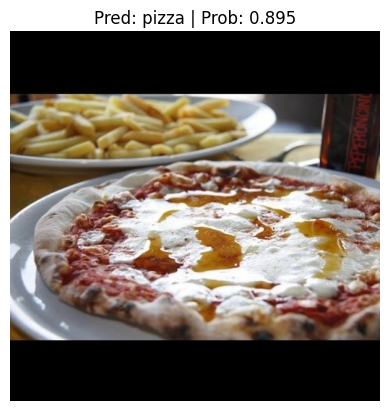

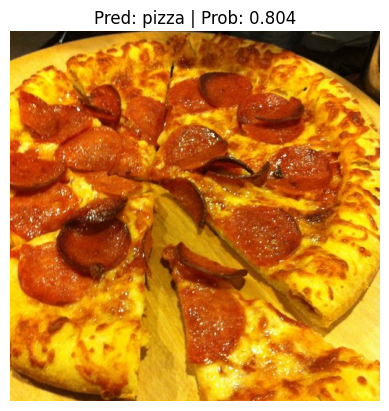

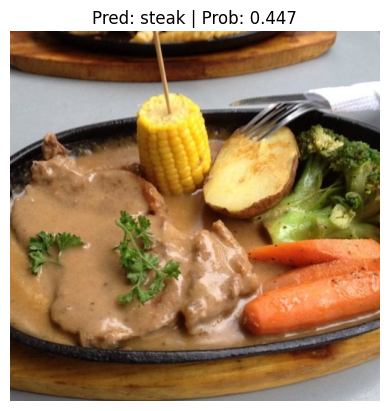

In [38]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

### Predict on a custom image with the best model

data/04-pizza-dad.jpeg already exists, skipping download.


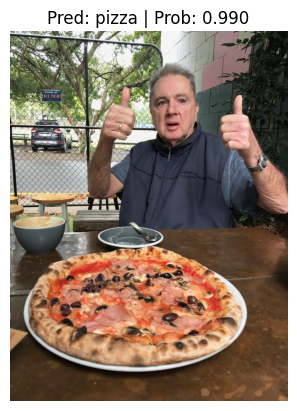

In [39]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)